## Setup evnironment

In [2]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from glob import glob
import json
import math
import mvranalysis as mvr

## Setup plotting

In [16]:
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
#import seaborn as sns
#sns.set_context('paper')
#sns.set_style('ticks')

In [191]:
switch = 20
path = '/Volumes/freeman/Nick/mVR/sessions/000101'

session = mvr.load_session(path)

In [192]:
maze = mvr.loadMazeMat(path+'/behavior')

OneChoiceLcts.mat
OneChoiceRcts.mat


In [193]:
#session.to_csv(path + '/behavior/session.csv')

#### Create trial summary

In [194]:
trial = session[['trialType','number']].groupby(['number'], sort=True).first()
trial = trial.join(session[['reward','number','rEnd','lEnd']].groupby(['number'], sort=True).max())

In [195]:
#Returns table of all trials and whether or not they entered a specific branch
def trialEntered(branchId):
    keep = session[['curBranchId','number']].groupby(['number'], sort=True).agg(lambda x : branchId in x.values)
    return keep

In [196]:
if trial.trialType[0] == 1:
    mazetype = 'switchR20'
else:
    mazetype = 'switchL20'
    
print mazetype

switchL20


In [197]:
numtrls = len(trial)
boundaries = range(0, numtrls+20,20)
print boundaries

[0, 20, 40, 60, 80]


# Characterize Maze per trial

In [198]:
submaze = []
for b in range(numtrls):
    if mazetype == 'switchL20':
        if math.floor((b+switch)/float(switch))%2==1:
            submaze.append('L')
        else:
            submaze.append('R')
    else: #switchR20
        if math.floor((b+switch)/float(switch))%2==1:
            submaze.append('R')
        else:
            submaze.append('L')

trial['rewardSide'] = submaze

## Plot data

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


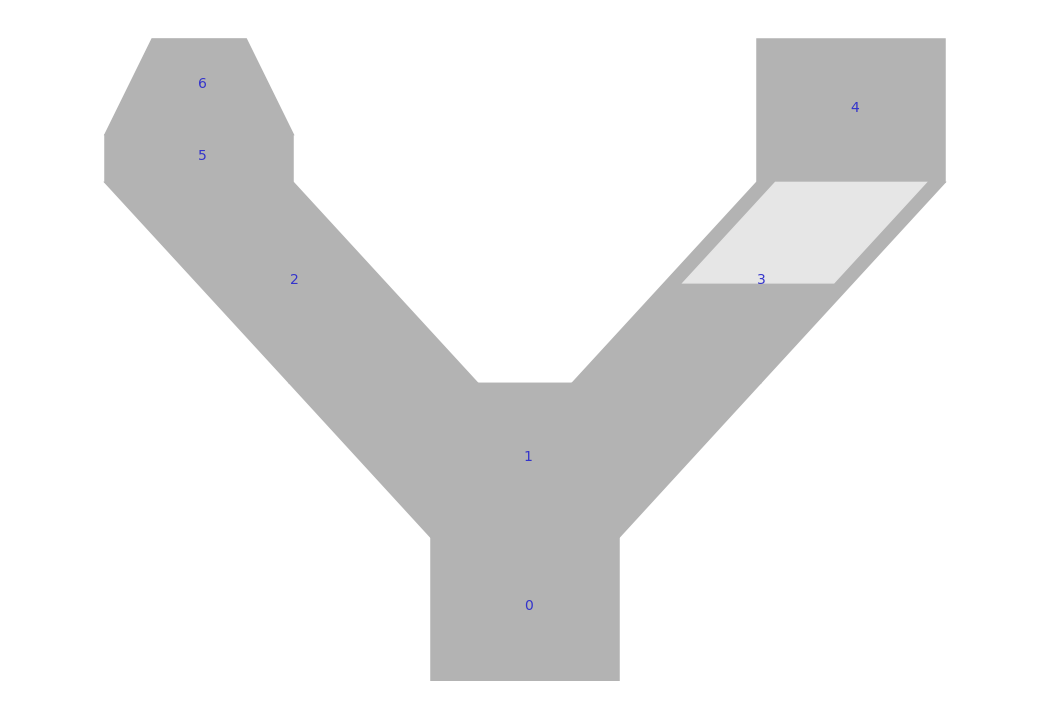

In [225]:
plt.figure(figsize=[18,12])
Id = 1
keep = trial[trial.trialType == Id].index.tolist()
print keep
mvr.draw(maze[Id],True)
#mvr.trace(session, keep, [0.1, 0.1, 0.1])
#mvr.licks(session, keep, [0.9, 0.1, 0.1])
#mvr.water(session, keep, [0.1, 0.8, 0.1])

In [200]:
def pathlength(x,y,degree=3)  :
    '''
    x and y arrays must have the same dimensions
    Implements arclength formula to estimate the total length of a fitted spline (cubic default)
    
    Returns: x(t) spline, y(t) spline, path length
    ''' 
    
    t = range(len(x)) #time series
    fx = interpolate.UnivariateSpline(t, x, k=degree)
    fy = interpolate.UnivariateSpline(t, y, k=degree)
    #print len(x),len(fx(t))
    x_coef = fx.get_coeffs()[~np.isnan(fx.get_coeffs())]
    y_coef = fy.get_coeffs()[~np.isnan(fy.get_coeffs())]
    
    dxdt = fx.derivative()
    dydt = fy.derivative()

    dx_array = [dxdt(xi) for xi in t]
    dy_array = [dydt(yi) for yi in t]

    dx2 = np.square(dx_array)
    dy2 = np.square(dy_array)

    hyp2 = np.add(dx2,dy2)
    integrand = np.sqrt(hyp2)

    length = sum(integrand)

    
    return fx, fy,length 

In [201]:
def fitpath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial :   
        xCord = session.xMazePos[(session.number == t) & ~session.iti].values[:-100]
        yCord = session.yMazePos[(session.number == t) & ~session.iti].values[:-100] 
    
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 

In [202]:
plen = fitpath(session,range(len(trial)))
#print plen, len(trial)
trial['Pathlengths'] = plen

In [203]:
def choicepath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial :   
        xCord = session.xMazePos[(session.number == t) & (session.curBranchId == 1) & ~session.iti].values
        yCord = session.yMazePos[(session.number == t) & (session.curBranchId == 1) & ~session.iti].values
        if len(xCord)==0:
            pathlengths.append('NaN')
            continue
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 
choicelen = choicepath(session,range(len(trial)))
trial['choicePath'] = choicelen
#trial


In [204]:
def initchoicepath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial : 
        inchoice = [(session.curBranchId==1) & (session.number==t)]
        if len(np.nonzero(inchoice)[1])==0:
            pathlengths.append(0)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        #print "enter 1 for trial"+str(t)+'='+str(enter1)
        inchoice = list(inchoice[0][enter1:])

        exit1 = enter1 + inchoice.index(0)
        #print "exit 1 for trial"+str(t)+'='+str(exit1)
        
        xCord = session.xMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values
        yCord = session.yMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values 
        #print len(xCord)
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 
initchoicelen = initchoicepath(session,range(len(trial)))
trial['initChoicePath'] = initchoicelen

11
3
16


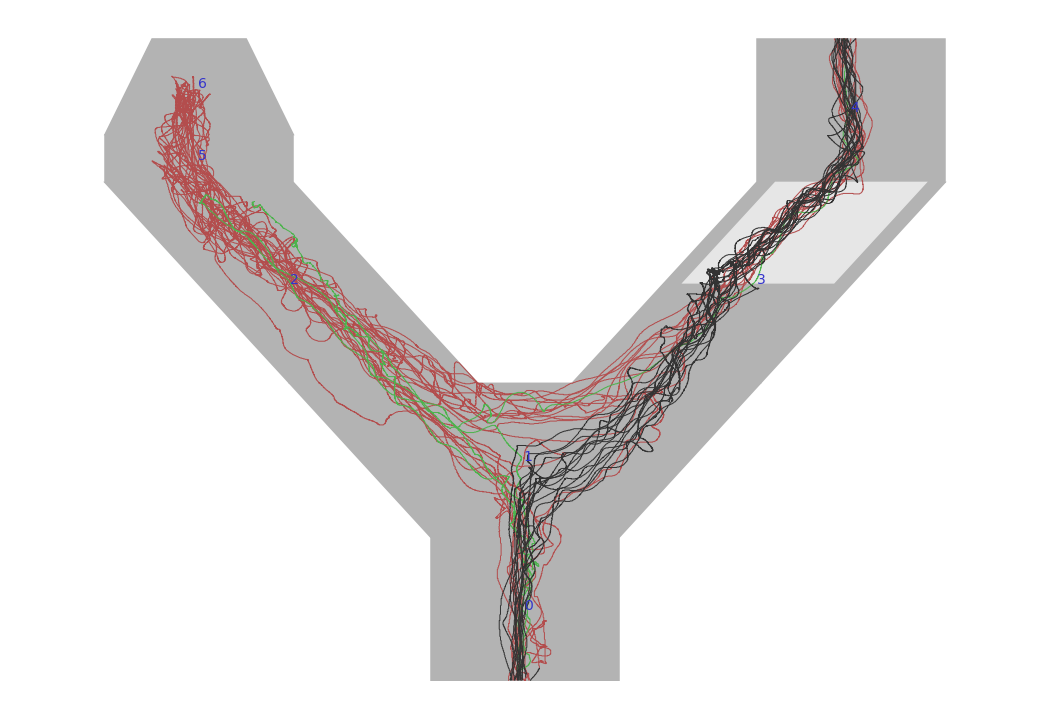

In [205]:
#For the Anti-bias Maze, Right Reward

plt.figure(figsize=[18,12])
Id = 1
mvr.draw(maze[Id],True)
branchId = 5 #dead end regardless of maze
keepE = trialEntered(branchId)



branchId = 2 #antibias right

keepW = trialEntered(branchId)


RkeepI = trial[(keepW.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(RkeepI)
mvr.trace(session, RkeepI, [0.7, 0.3, 0.3]) #incorrect
RkeepS = trial[(keepW.curBranchId == True) & (keepE.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(RkeepS)
mvr.trace(session, RkeepS, [0.3, 0.7, 0.3]) #entered wrong branch but corrected itself
RkeepC = trial[(keepW.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(RkeepC)
mvr.trace(session, RkeepC, [0.2, 0.2, 0.2]) #correct
  


1
0
39


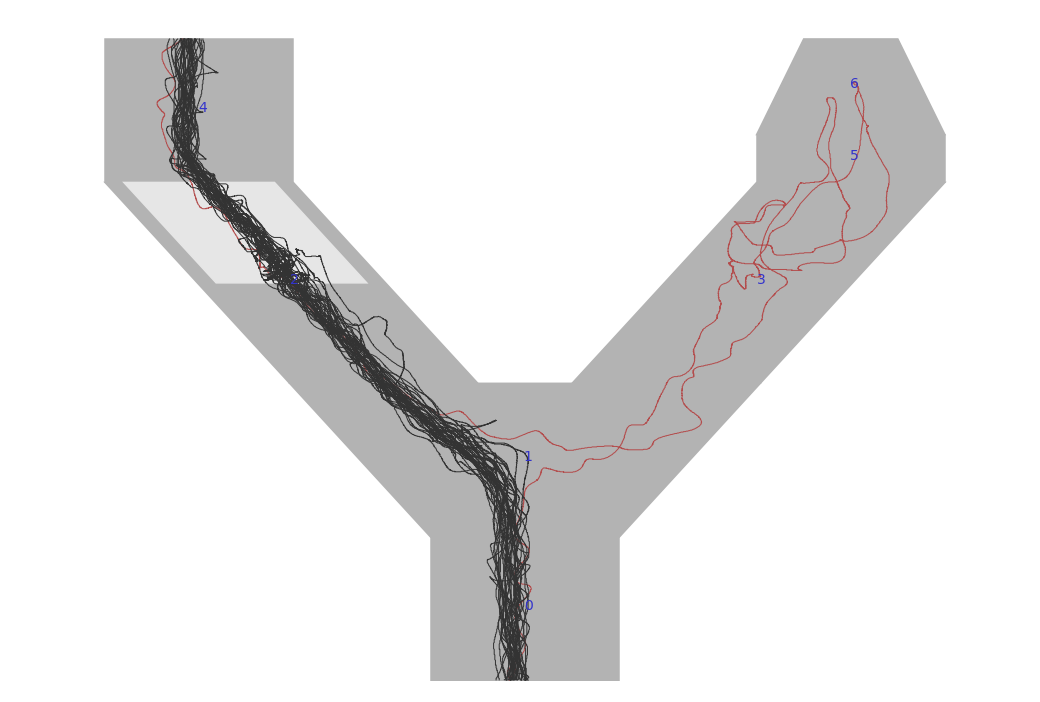

In [206]:
#For the Anti-bias maze, Left Reward
plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)
branchId = 5 #dead end regardless of maze
keepE = trialEntered(branchId)


branchId = 3 #antibias left

keepW = trialEntered(branchId)

LkeepI = trial[(keepW.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(LkeepI)
mvr.trace(session, LkeepI, [0.7, 0.3, 0.3]) #incorrect
LkeepS = trial[(keepW.curBranchId == True) & (keepE.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(LkeepS)
mvr.trace(session, LkeepS, [0.3, 0.7, 0.3]) #entered wrong branch but corrected itself
LkeepC = trial[(keepW.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(LkeepC)
mvr.trace(session, LkeepC, [0.2, 0.2, 0.2]) #correct

In [207]:
a = LkeepI+LkeepS+LkeepC +RkeepI + RkeepS + RkeepC
a.sort()
#print LkeepC
#print a

In [208]:
#Classified into array

def init_choice(numtrials):    
    choices = ["" for x in range(numtrials)]

    for x in range(len(choices)):
        #if maze[0].get('name') == "u'OneChoiceLcts.mat'":
            if x in LkeepI:
                choices[x] = "R"
            elif x in LkeepS:
                choices[x] = "RL"
            elif x in LkeepC:
                choices[x] = "L"
            elif x in RkeepI:
                choices[x] = "L"
            elif x in RkeepS:
                choices[x] = "LR"
            else:
                choices[x] = "R"
    return choices

choices = init_choice(numtrls)
print len(trial), len(choices)

trial ['Trajectory'] = choices
trial['initChoice']   = [x[:1] for x in choices] 
#print trial

70 70


In [209]:
b = [] #Classify left and Right binary
for i in trial.initChoice:
    if i =='L':
        b.append(0)
    else:
        b.append(1)
print len(b)        

70


# Create Dot Plot

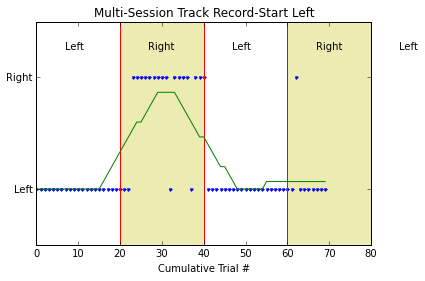

In [210]:
plt.plot(b,'.')
plt.ylim((-0.5,1.5))
plt.xlim((0,max(boundaries)))
#in which 1 = left and 0 = right
[plt.axvline(x =a, color='r') for a in boundaries]
plt.axvspan(boundaries[1],boundaries[2], facecolor = 'y', alpha = 0.3)
plt.axvspan(boundaries[3],boundaries[4], facecolor = 'y', alpha = 0.3)
#plt.axvspan(boundaries[5],boundaries[6], facecolor = 'y', alpha = 0.3)
plt.xlabel('Cumulative Trial #')

if mazetype == 'switchL20':
    plt.yticks([0,1],['Left','Right'])
    plt.title('Multi-Session Track Record-Start Left')
    plt.text(7, 1.25, 'Left')
    plt.text(27, 1.25, 'Right')
    plt.text(47, 1.25, 'Left')
    plt.text(67, 1.25, 'Right')
    plt.text(87, 1.25, 'Left')
else:
    plt.yticks([0,1],['Left','Right'])
    plt.title('Multi-Session Track Record-Start Right') 
    plt.text(7, 1.25, 'Right')
    plt.text(27, 1.25, 'Left')
    plt.text(47, 1.25, 'Right')
    plt.text(67, 1.25, 'Left')
    plt.text(87, 1.25, 'Right')
    plt.text(107, 1.25, 'Left')

avgs = []
binsize = 15
kernel = np.ones(binsize,)/float(binsize)
avgs = np.convolve(b,kernel, 'same')
plt.plot(avgs) 

In [211]:
def dead_end(numtrials):
    end = trialEntered(6)             
    return end

deadends = dead_end(numtrls)
trial['deadEnd'] = deadends
#print trial

# Create Bar Graph - overall performance

40 30
0.975 0.533333333333 0.025 0.466666666667


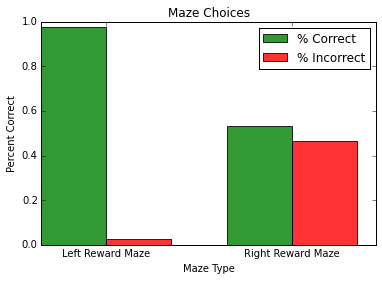

In [212]:
#Total bias split, based on initial choices

percent_correct = (len(LkeepC) +len (RkeepC))/float(numtrls)
percent_wrong = ((len(RkeepS)+len(RkeepI))+len(LkeepS)+len(LkeepI))/float(numtrls)
percent_qswitch = (len(RkeepS)+len(LkeepS))/float(numtrls)

#print percent_correct,percent_wrong, percent_qswitch

numleft = len(LkeepC+LkeepI+LkeepS)
numright = len(RkeepC+RkeepS+RkeepI)

left_corr = len(LkeepC)/float(numleft)
right_corr = len(RkeepC)/float(numright)
left_wrong = (len(LkeepS)+len(LkeepI))/float(numleft)
right_wrong = (len(RkeepS)+len(RkeepI))/float(numright)

print numleft,numright
print left_corr, right_corr, left_wrong, right_wrong

labels = ('Left Reward Maze', 'Right Reward Maze')  #Unbiased days
y_pos = np.arange(len(labels))
fig, ax = plt.subplots()

bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(y_pos, [left_corr,right_corr], bar_width,
                 alpha=opacity,
                 color='g',
                 label= '% Correct')
 
rects2 = plt.bar(y_pos + bar_width, [left_wrong,right_wrong], bar_width,
                 alpha=opacity,
                 color='r',
                 label= '% Incorrect')

plt.legend(loc='best')
plt.xticks(y_pos+bar_width, labels)
plt.xlabel('Maze Type')
plt.ylabel('Percent Correct')
plt.title('Maze Choices')
plt.show()

In [213]:
def completion(session, numtrials):
    finish = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        if (stop-start) > 119:
            entry = False
        else:
            entry = True
        finish.append(entry)
    return finish

complete = completion(session,numtrls)
trial['Completed'] = complete

incomplete = complete.count(False)
percent_unfin = incomplete/float(len(complete))
print incomplete,percent_unfin


2 0.0285714285714


In [214]:
def trial_time(session, numtrials):
    seconds = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        seconds.append(stop-start)
    return seconds    
        
times = trial_time(session,numtrls)

trial['time'] = times


In [215]:
def choice_time(session,numtrials):
    think = []
    straight = []
    choicept = 1
    entrance = 0
    dt = 0.002
    for n in range(numtrials):
        in1 = len(session[session.number==n].time[session.curBranchId==choicept])*dt
        in0 = len(session[session.number==n].time[session.curBranchId==entrance])*dt
        
        think.append(in1)
        straight.append(in0)
    return think,straight

t_choosing,t_straight = choice_time(session,numtrls)
trial['timeStraight'] = t_straight
trial['timeChoice'] = t_choosing

#print trial

In [216]:
def initchoice_time(session,numtrials):
    dt = 0.002 #seconds per timestep
    initchoice_t = []
    for n in range(numtrials):
        inchoice = [(session.curBranchId==1) & (session.number==n)]
        if len(np.nonzero(inchoice)[1])==0:
            initchoice_t.append(0)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        inchoice = list(inchoice[0][enter1:])
        exit1 = enter1 + inchoice.index(0)
        initchoice_t.append((exit1-enter1)*dt)
    return initchoice_t

initchoice_t= initchoice_time(session,numtrls)
trial['initChoiceTime'] = initchoice_t
#trial    

In [217]:
import math
def Idphi(x,y,degree=3):
    '''
    x and y arrays must have the same dimensions
    Implements arclength formula to estimate the total length of a fitted spline (cubic default)
    
    Returns: idphi
    ''' 
    
    t = range(len(x)) #time series
    dx_array = np.diff(x)
    dy_array = np.diff(y)
    d = range(len(dx_array))
    phi = [math.atan2(dy_array[i],dx_array[i]) for i in d]
    phi = np.unwrap(phi)
    phispline = interpolate.UnivariateSpline(range(len(phi)),phi, k=degree)
   
    dphispline = phispline.derivative()
    '''
    plt.plot(x,y)
    plt.xlim(0,70)
    plt.figure()
    plt.plot(phi)
    plt.plot(d,phispline(d))
    plt.figure()
    plt.plot(d,dphispline(d))
    '''
    
    dphi = [abs(i) for i in dphispline(d)]
    result = sum(dphi)
    
    return result
    
#x = [10,10,10,10,20,30,40,50,60,60,60]
#y = [0,10,20,30,30,30,30,30,30,50,60]

#Idphi(x,y)  

In [218]:
def get_idphi(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    idphi = []    
    for t in trial : 
        inchoice = [(session.curBranchId==1) & (session.number==t)]
        
        if len(np.nonzero(inchoice)[1])==0:
            idphi.append(np.nan)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        
        inchoice = list(inchoice[0][enter1:])

        exit1 = enter1 + inchoice.index(0)
        
        exitbranch = session.curBranchId[(session.trialIndex==exit1)].values[0]
        
        if not (exitbranch ==2 or exitbranch==3):
            idphi.append(np.nan)
            continue 
        
        xCord = session.xMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values
        yCord = session.yMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values 
       
        idphi.append(Idphi(xCord,yCord))
    return idphi

idphi = get_idphi(session,range(len(trial)))
trial['IdPhi'] = idphi     

In [219]:
zidphi = ((trial.IdPhi - trial.IdPhi.mean())/trial.IdPhi.std(ddof=0))
#print zidphi
trial['zIdPhi'] = zidphi

In [220]:
trial

,trialType,reward,rEnd,lEnd,rewardSide,Pathlengths,choicePath,initChoicePath,Trajectory,initChoice,deadEnd,Completed,time,timeStraight,timeChoice,initChoiceTime,IdPhi,zIdPhi
number,,,,,,,,,,,,,,,,,,
0,0,1,0,0,L,96.300813,31.842471,31.798975,L,L,False,True,7.508,2.180,1.478,1.478,1.100652,-0.266379
1,0,1,0,0,L,100.235692,34.857985,34.796792,L,L,False,True,8.124,0.628,2.452,2.452,119.359739,7.281680
2,0,1,0,0,L,95.556791,23.152090,23.112002,L,L,False,True,5.998,0.718,1.180,1.180,0.753123,-0.288560
3,0,1,0,0,L,91.239906,29.871879,29.819594,L,L,False,True,5.256,0.560,1.086,1.086,0.697316,-0.292122
4,0,1,0,0,L,90.748764,29.519110,29.457840,L,L,False,True,6.960,0.610,1.534,1.534,0.702671,-0.291781
5,0,1,0,0,L,95.659339,29.732311,29.657398,L,L,False,True,5.668,0.762,1.026,1.026,1.462107,-0.243308
6,0,1,0,0,L,84.956564,28.092201,28.059699,L,L,False,True,4.914,0.468,1.064,1.064,1.805875,-0.221367
7,0,1,0,0,L,92.676396,24.116624,24.081114,L,L,False,True,5.460,0.630,0.892,0.892,1.264512,-0.255920
8,0,1,0,0,L,86.991151,27.803630,27.738022,L,L,False,True,5.550,0.486,1.040,1.040,0.834916,-0.283340


In [221]:
newfolder = path+'/summary'

In [222]:
#os.mkdir(newfolder)

In [223]:
trial.to_csv(newfolder + '/trial_summary101.csv')